$$
dx = f(x, t) \, dt + L(x, t) \, d\beta,
\quad
d\beta \, d\beta^{\top} = Q dt,
\quad
x(0) = x_0.
$$

$$
\frac{\partial \rho(x, t)}{\partial t} =
    - \sum_{i=1}^d
        \frac{\partial}{\partial x_i}
        \left[ f_i(x, t) \rho(x, t) \right]
    + \sum_{i=1}^d \sum_{j=1}^d
        \frac{\partial^2}{\partial x_i \partial x_j}
        \left[ D_{ij}(x, t) \rho(x, t) \right],
\quad
\rho(x, 0) = \rho_0(x).
$$

$$
D(x, t) = \frac{1}{2} L(x, t) Q L^{\top}(x, t).
$$

Let consider simple case $f(x, t) = Ax$, $D(x, t) = I$, then we have to solve

$$
\frac{\partial \rho}{\partial t} = \Delta \rho - div \left[ A x \rho \right],
\quad
\rho(x, 0) = \rho_0(x).
$$

In [41]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse import kron as kron
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from scipy.interpolate import RectBivariateSpline
from IPython.display import HTML

In [42]:
# SDE parameters | dx = Ax dt + dW

A = np.array([
    [1.0, 0.0],
    [1.0, 1.0],
])

In [43]:
# Time grid

t_min = 0.
t_max = 1.
t_poi = 10

h = (t_max - t_min) / (t_poi - 1)
T = np.linspace(t_min, t_max, t_poi)

In [44]:
# Spatial grid

x_min = -3.
x_max = +3.
x_poi = 10

X = np.linspace(x_min, x_max, x_poi)
X1, X2 = np.meshgrid(X, X)
X = np.array([X1, X2])
X = X.reshape((2, -1))

l = (x_max - x_min) / x_poi

In [45]:
# Initial condition for x

x0 = X.copy()

In [46]:
# Initial condition for r

r0 = np.exp(-0.5 * np.diag(x0.T@x0)).reshape(-1, 1)

In [47]:
n = x_poi
I = np.eye(n)
L = sp.spdiags([ [1.]*n, [-2.]*n, [1.]*n ], [-1, 0, 1], n, n).tocsr() / l / l
C = sp.spdiags([ [-0.5]*n, [0.5]*n ], [-1, 1], n, n).tocsr() / l

In [53]:
def step(x0, r0):
    F = A@x0
    F1 = np.diag(F[0, :])
    F2 = np.diag(F[1, :])
    M = kron(L, I) + kron(I, L) - kron(C, I)@F1 - kron(I, C)@F2

    # x = x0 + h * F + np.sqrt(h) * np.random.randn(*x0.shape)
    x = x0
    r = r0 + M@r0 * h
    
    return (x, r)

In [54]:
def calc():
    x = x0.copy()
    r = r0.copy()

    X_list = [x]
    R_list = [r]
    
    for _ in range(t_poi-1):
        x, r = step(x, r)
        X_list.append(x)
        R_list.append(r)
    
    return (X_list, R_list)

In [55]:
# Run caclulations

X_list, R_list = calc()

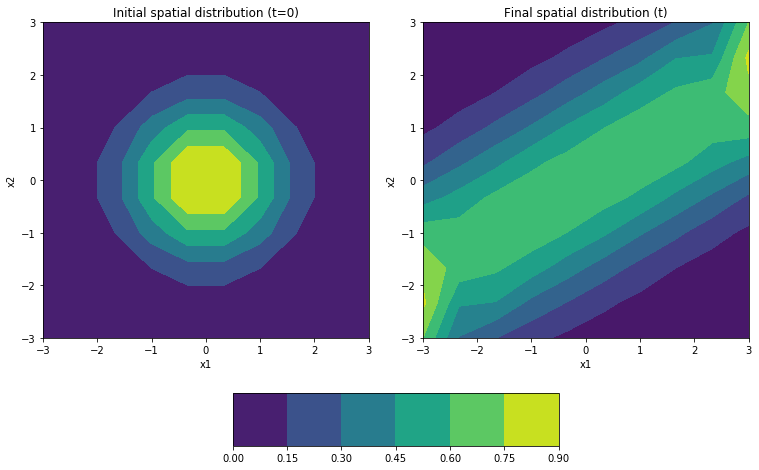

In [56]:
# Plot distribution (initial and final) on spatial grid

fig = plt.figure(figsize=(10, 6))
gs = mpl.gridspec.GridSpec(
    ncols=4, nrows=2, left=0.01, right=0.99, top=0.99, bottom=0.01,
    wspace=0.4, hspace=0.3, width_ratios=[1, 1, 1, 1], height_ratios=[6, 1]
)

ax = fig.add_subplot(gs[0, :2])
ct1 = ax.contourf(X1, X2, R_list[0].reshape((x_poi, x_poi)))
ax.set_title('Initial spatial distribution (t=0)')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

ax = fig.add_subplot(gs[0, 2:])
ct2 = ax.contourf(X1, X2, R_list[-1].reshape((x_poi, x_poi)))
ax.set_title('Final spatial distribution (t)')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

ax = fig.add_subplot(gs[1, 1:3])
cb = plt.colorbar(ct1, cax=ax, orientation='horizontal')
# cb.add_lines(ct2)

plt.show()

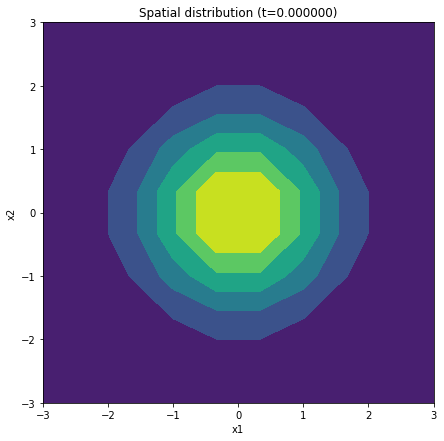

In [57]:
# Build animation for distribution

# Interval between frames
delt = 200 

# Path to ffmpeg executable
plt.rcParams['animation.ffmpeg_path'] = './../tmp/ffmpeg'

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

def run(i):
    t = T[i]
    r = R_list[i].reshape((x_poi, x_poi))

    ax.clear()
    ax.set_title('Spatial distribution (t=%f)'%t)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ct = ax.contourf(X1, X2, r)
    return (ct,)

anim = animation.FuncAnimation(fig, run, frames=len(T), interval=delt, blit=False)
HTML(anim.to_html5_video())